In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import scipy
import torch.functional as F
import optuna
import torch.nn as nn
import torch
#import shap
import glob
import seaborn as sns
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [110]:
def prepare_cat_features(data: pd.DataFrame, cat_features: list) -> pd.DataFrame:
    """
    Преобразует категориальные признаки в целые числа или строки для CatBoost
    
    Args:
        data: исходный датафрейм
        cat_features: список категориальных признаков
    
    Returns:
        DataFrame с преобразованными категориальными признаками
    """
    result = data.copy()
    
    for feature in cat_features:
        if result[feature].dtype == float:
            if result[feature].apply(lambda x: x.is_integer()).all():
                result[feature] = result[feature].astype(int)
            else:
                result[feature] = result[feature].astype(str)
        elif result[feature].dtype != int:
            result[feature] = result[feature].astype(str)
            
    return result

In [111]:
path_train = 'train'
path_test = 'test'
filenames_train = glob.glob(path_train + "/*.csv")
data_files_train = []

for filename in filenames_train:
    data_files_train.append(pd.read_csv(filename))

data_train = pd.concat(data_files_train, ignore_index=True)

filenames_test = glob.glob(path_test + "/*.csv")

data_files_test = []

for filename in filenames_test:
    data_files_test.append(pd.read_csv(filename))

data_test = pd.concat(data_files_test, ignore_index=True)
ids = data_test['id']

X_train = data_train.drop(['target', 'smpl', 'id'], axis=1)
y_train = data_train['target']

X_test = data_test.drop(['smpl'], axis=1)

<AxesSubplot: >

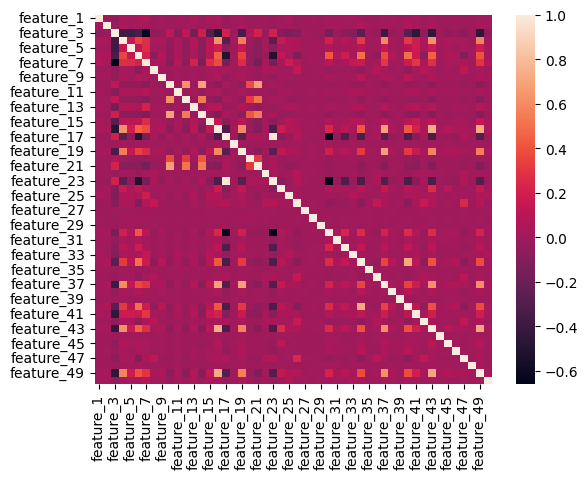

In [112]:
sns.heatmap(X_train.iloc[:, :50].corr())

In [113]:
cat_features = ['feature_3', 'feature_10', 'feature_12', 'feature_14', 'feature_15', 'feature_17', 'feature_20', 'feature_21', 'feature_23', 'feature_54', 'feature_60', 'feature_70', 'feature_92', 'feature_98', 'feature_101', 'feature_126', 'feature_135', 'feature_137', 'feature_142', 'feature_153', 'feature_179', 'feature_187', 'feature_198', 'feature_242', 'feature_244', 'feature_255', 'feature_270', 'feature_312', 'feature_330', 'feature_339', 'feature_341', 'feature_342', 'feature_372', 'feature_375', 'feature_383', 'feature_396', 'feature_411']
num_features = [col for col in X_train.columns if col not in cat_features]

In [114]:
len(num_features), len(cat_features)

(381, 37)

Text(0.5, 1.0, 'Correlation Matrix (|correlation| > 0.9)')

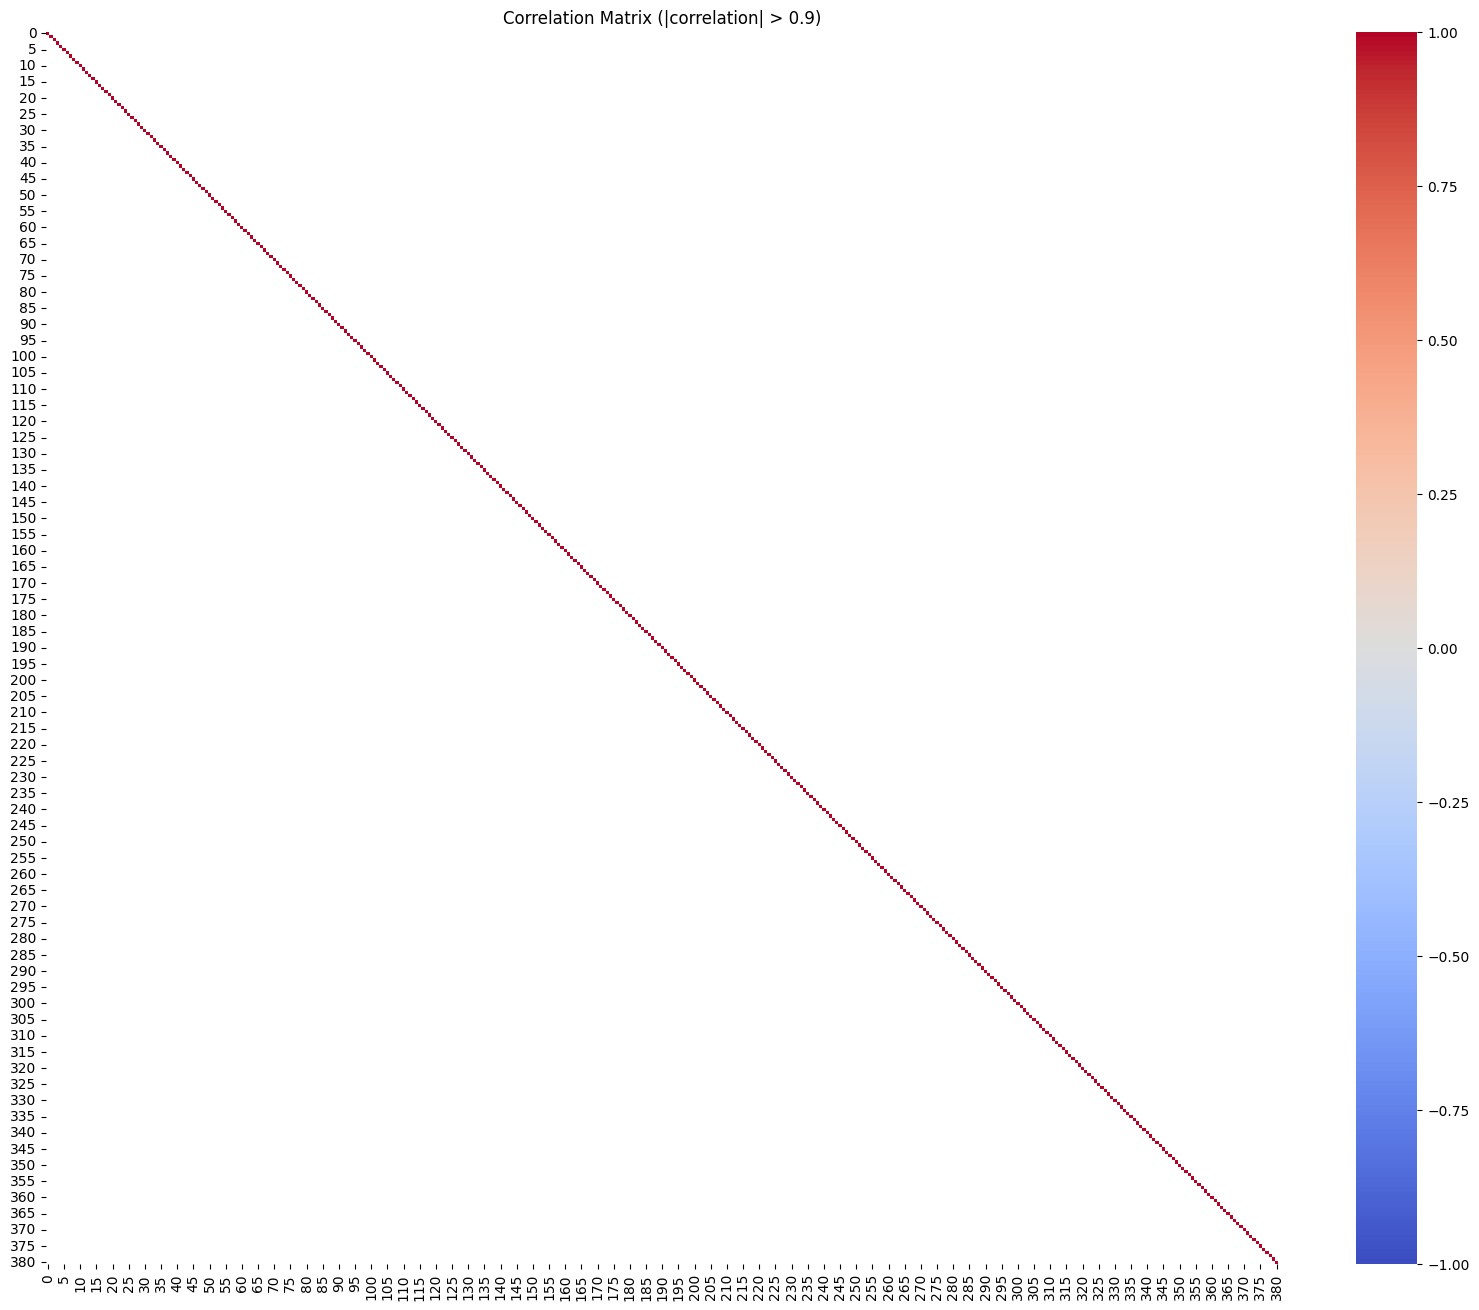

In [ ]:
from sklearn.decomposition import PCA
X_scaled = X_train[num_features]
pca = PCA(n_components=381)
pca.fit(X_scaled)
correlation_matrix = pd.DataFrame(pca.transform(X_scaled)).corr()

threshold = 0.9
mask = np.abs(correlation_matrix) <= threshold
plt.figure(figsize=(20, 16))

sns.heatmap(correlation_matrix,
            mask=mask,
            cmap='coolwarm',
            center=0,
            vmin=-1, vmax=1,
            square=True)

plt.title(f'Correlation Matrix (|correlation| > {threshold})')

In [116]:
pca_data = pd.DataFrame(pca.transform(X_scaled))
pca_data = pd.concat((pca_data, X_train[cat_features]), axis=1)
pca_data = prepare_cat_features(pca_data, cat_features)
pca_data.head()

,0,1,2,3,4,5,6,7,8,9,...,feature_312,feature_330,feature_339,feature_341,feature_342,feature_372,feature_375,feature_383,feature_396,feature_411
0,3.091222,3.740722,-4.309893,0.365082,-0.451867,2.340354,0.697075,-2.883879,0.687058,0.446263,...,0,3,6,4,0,4,0,0,3,0
1,-2.535524,2.606287,-2.783584,-1.995098,-1.067119,-1.041435,1.058962,3.189721,2.329249,3.531805,...,0,3,1,4,0,4,0,0,3,0
2,-4.736480,3.313060,2.009396,1.117386,-0.728042,0.091390,-2.186728,-0.110871,1.538669,-0.341483,...,0,3,2,4,1,4,0,0,3,0
3,-2.140070,5.103363,1.730248,0.742222,-1.903957,0.091610,-0.928141,-0.946122,0.867813,4.070737,...,0,3,3,4,1,4,0,0,3,0
4,-5.659993,1.204940,-0.582243,0.871724,-1.952244,1.057601,-0.457748,-2.299053,1.394126,2.015312,...,0,3,1,4,0,4,0,0,3,0


In [117]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
unique_counter = {}

for feature in cat_features:
    label_encoders[feature] = LabelEncoder()
    
    X_train[feature] = label_encoders[feature].fit_transform(X_train[feature])
    
    unique_counter[feature] = len(label_encoders[feature].classes_)
    
    print(f"Feature {feature}:")
    print(f"Number of unique values: {unique_counter[feature]}")
    print(f"Value range: [{X_train[feature].min()}, {X_train[feature].max()}]")
    print("---")

for feature in cat_features:
    X_eval[feature] = label_encoders[feature].transform(X_eval[feature])


Feature feature_3:
Number of unique values: 2
Value range: [0, 1]
---
Feature feature_10:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_12:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_14:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_15:
Number of unique values: 2
Value range: [0, 1]
---
Feature feature_17:
Number of unique values: 4
Value range: [0, 3]
---
Feature feature_20:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_21:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_23:
Number of unique values: 4
Value range: [0, 3]
---
Feature feature_54:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_60:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_70:
Number of unique values: 3
Value range: [0, 2]
---
Feature feature_92:
Number of unique values: 7
Value range: [0, 6]
---
Feature feature_98:
Number of unique values: 3
Value range: [0, 2]
---
Feature

In [119]:
X_train[cat_features] = X_train[cat_features].astype(int)
X_eval[cat_features] = X_eval[cat_features].astype(int)

In [ ]:
class CreditTransformer(nn.Module):
    def __init__(self, input_num_dim, categorical_dict, categorical_dim=24, hidden_dim=512, n_layers=8, dropout=0.1):
        super().__init__()

        self.input_num_dim = input_num_dim
        self.categorical_dim = categorical_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.embs = nn.ModuleList([nn.Embedding(cat_count, categorical_dim) for cat_feature, cat_count in categorical_dict.items()])

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=categorical_dim,
            nhead=8,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.cat_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.num_processor = nn.Sequential(
            nn.Linear(input_num_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        total_features = categorical_dim + hidden_dim

        self.final_dense = nn.Sequential(
            nn.Linear(total_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    
    def forward(self, X_numerical, X_categorical):
        categorical_embeddings = []
        for i, emb in enumerate(self.embs):
            categorical_embeddings.append(emb(X_categorical[:, i]))
        

        categorical_embeddings = torch.stack(categorical_embeddings, dim=1)
        
        src_mask = None
        categorical_encoded = self.cat_encoder(categorical_embeddings, src_mask)
        categorical_encoded = torch.mean(categorical_encoded, dim=1)
        
        num_features = self.num_processor(X_numerical)
        
        
        combined_features = torch.cat([
            categorical_encoded,
            num_features
        ], dim=1)
        
        output = self.final_dense(combined_features)
        return output

In [121]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([ 0.5110, 23.2264])

In [124]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
import pandas as pd

def prepare_data(df, categorical_columns, numeric_columns):
    """
    Prepare numeric and categorical data separately
    """
    numeric_features = df[numeric_columns].values
    numeric_tensor = torch.FloatTensor(numeric_features)
    
    categorical_features = df[categorical_columns].values
    categorical_tensor = torch.LongTensor(categorical_features)
    
    return numeric_tensor, categorical_tensor

X_train_num, X_train_cat = prepare_data(X_train, 
                                      categorical_columns=cat_features,
                                      numeric_columns=num_features)
X_eval_num, X_eval_cat = prepare_data(X_eval,
                                    categorical_columns=cat_features,
                                      numeric_columns=num_features)
X_train_num = X_train_num.to(device)
X_eval_num = X_eval_num.to(device)
X_train_cat = X_train_cat.to(device)
X_eval_cat = X_eval_cat.to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_eval = torch.FloatTensor(y_eval.values)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, numeric_features, categorical_features, targets):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.targets = targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return (self.numeric_features[idx], self.categorical_features[idx]), self.targets[idx]

train_dataset = CustomDataset(X_train_num, X_train_cat, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [141]:
class AUCLoss(nn.Module):
    def __init__(self, temperature=1.0):
        """
        Args:
            temperature: Softmax temperature parameter to control the smoothness
                        of the approximation
        """
        super().__init__()
        self.temperature = temperature

    def forward(self, predictions, targets):
        """
        Args:
            predictions: Model predictions (batch_size, 1)
            targets: Ground truth labels (batch_size, 1)
        Returns:
            loss: Approximated AUC loss
        """
        pos_mask = (targets == 1)
        neg_mask = (targets == 0)
        
        pos_preds = predictions[pos_mask]
        neg_preds = predictions[neg_mask]
        
        pos_preds = pos_preds.unsqueeze(1)
        neg_preds = neg_preds.unsqueeze(0)
        
        diff_matrix = pos_preds - neg_preds
        
        loss = -torch.log(torch.sigmoid(self.temperature * diff_matrix).clamp(min=1e-8, max = 1 - 1e-8))
        return torch.mean(loss)

In [162]:
class ImprovedAUCLoss(nn.Module):
    def __init__(self, temperature=1.0, margin=1.0, eps=1e-6):
        """
        Args:
            temperature: Controls the smoothness of the approximation
            margin: Minimum desired difference between positive and negative scores
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.temperature = temperature
        self.margin = margin
        self.eps = eps

    def forward(self, predictions, targets):
        """
        Args:
            predictions: Model predictions (batch_size, 1)
            targets: Ground truth labels (batch_size, 1)
        Returns:
            loss: Improved AUC loss with margin and numerical stability
        """
        # Handle edge cases
        pos_mask = (targets == 1)
        neg_mask = (targets == 0)
        
        if not torch.any(pos_mask) or not torch.any(neg_mask):
            return torch.tensor(0.0, device=predictions.device, requires_grad=True)
        
        # Clip predictions for numerical stability
        predictions = torch.clamp(predictions, min=-10, max=10)
        
        pos_preds = predictions[pos_mask]
        neg_preds = predictions[neg_mask]
        
        # Handle empty tensors
        if len(pos_preds) == 0 or len(neg_preds) == 0:
            return torch.tensor(0.0, device=predictions.device, requires_grad=True)
        
        pos_preds_exp = pos_preds.unsqueeze(1)  # (num_pos, 1)
        neg_preds_exp = neg_preds.unsqueeze(0)  # (1, num_neg)
        
        # Calculate difference matrix with scaled temperature
        diff_matrix = self.temperature * (pos_preds_exp - neg_preds_exp)  # (num_pos, num_neg)
        
        # Apply margin loss with numerical stability
        hinge_loss = torch.clamp(self.margin - diff_matrix, min=0)
        
        # Average the loss only over non-zero elements
        non_zero_elements = torch.sum(hinge_loss > 0).float() + self.eps
        loss = torch.sum(hinge_loss) / non_zero_elements
        
        # Verify loss is finite
        if not torch.isfinite(loss):
            return torch.tensor(0.0, device=predictions.device, requires_grad=True)
            
        return loss


In [163]:
def train_and_validate(model, train_loader, X_eval_num, X_eval_cat, y_eval, 
                      criterion, optimizer, num_epochs=10, device='cuda'):
    
    model = model.to(device)
    train_losses = []
    val_auc_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for (batch_X_num, batch_X_cat), batch_y in tqdm(train_loader, 
                                                       desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_X_num = batch_X_num.to(device)
            batch_X_cat = batch_X_cat.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(batch_X_num, batch_X_cat)
            if len(criterion) > 1:
                loss = 0.8 * criterion[0](outputs, batch_y.view(-1, 1))
                loss += 0.2 * criterion[1](outputs, batch_y.view(-1, 1))
            else:
                loss = criterion[0](outputs, batch_y.view(-1, 1))
                
            
            loss.backward()
            
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)
        
        model.eval()
        best_auc = float('-inf')
        with torch.no_grad():
            X_eval_num = X_eval_num.to(device)
            X_eval_cat = X_eval_cat.to(device)
            y_eval = y_eval.to(device)
            
            val_outputs = model(X_eval_num, X_eval_cat)
            val_outputs = torch.sigmoid(val_outputs)
            
            val_auc = roc_auc_score(y_eval.cpu().numpy(), 
                                  val_outputs.cpu().numpy())
            val_auc_scores.append(val_auc)
            
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model.state_dict().copy()
            
            plt.plot(val_auc_scores, label='Validation AUC', color='orange')
            plt.title('Validation ROC-AUC over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('ROC-AUC Score')
            plt.grid(True)
            plt.legend()
            plt.show()
            
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Average Training Loss: {avg_train_loss:.4f}')
            print(f'Validation ROC-AUC: {val_auc:.4f}')
            print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'val_auc_scores': val_auc_scores,
        'best_model': best_model,
        'best_auc': best_auc
    }

Epoch 1/10: 100%|██████████| 969/969 [00:22<00:00, 43.89it/s]


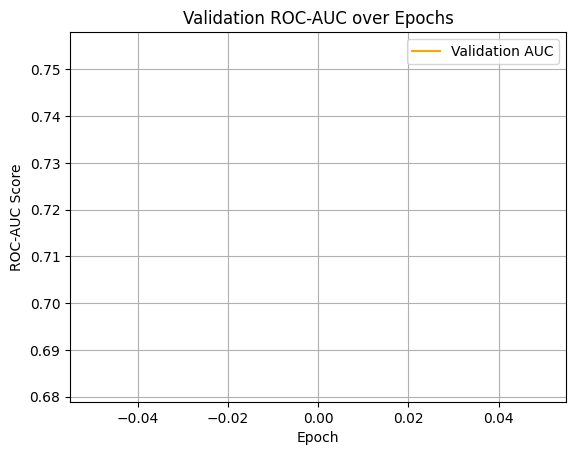

Epoch 1/10:
Average Training Loss: 0.8240
Validation ROC-AUC: 0.7184
--------------------------------------------------


Epoch 2/10: 100%|██████████| 969/969 [00:20<00:00, 46.39it/s]


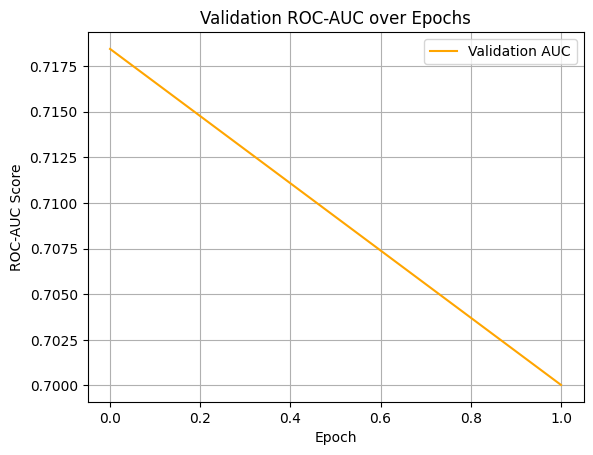

Epoch 2/10:
Average Training Loss: 0.7548
Validation ROC-AUC: 0.7000
--------------------------------------------------


Epoch 3/10: 100%|██████████| 969/969 [00:21<00:00, 44.72it/s]


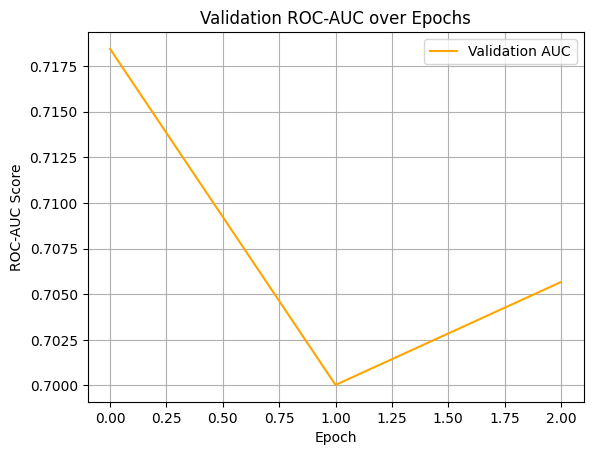

Epoch 3/10:
Average Training Loss: 0.7023
Validation ROC-AUC: 0.7057
--------------------------------------------------


Epoch 4/10: 100%|██████████| 969/969 [00:24<00:00, 39.93it/s]


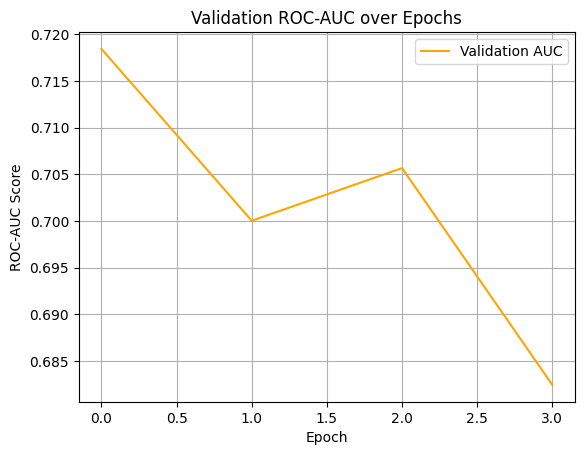

Epoch 4/10:
Average Training Loss: 0.6579
Validation ROC-AUC: 0.6824
--------------------------------------------------


Epoch 5/10: 100%|██████████| 969/969 [00:20<00:00, 47.66it/s]


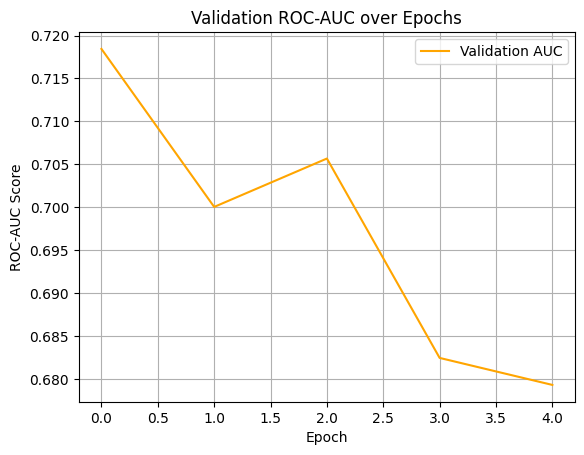

Epoch 5/10:
Average Training Loss: 0.6110
Validation ROC-AUC: 0.6793
--------------------------------------------------


Epoch 6/10: 100%|██████████| 969/969 [00:21<00:00, 44.29it/s]


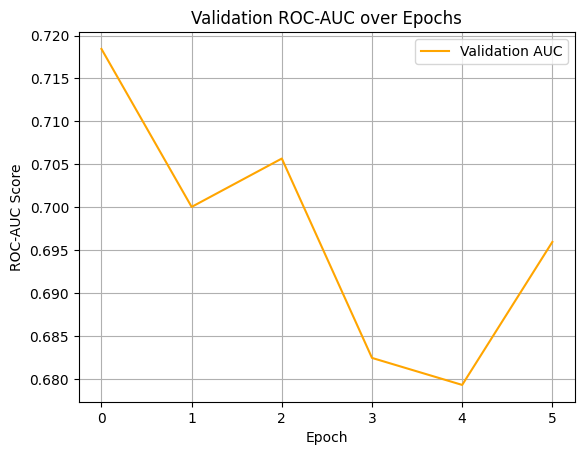

Epoch 6/10:
Average Training Loss: 0.5664
Validation ROC-AUC: 0.6960
--------------------------------------------------


Epoch 7/10: 100%|██████████| 969/969 [00:21<00:00, 45.74it/s]


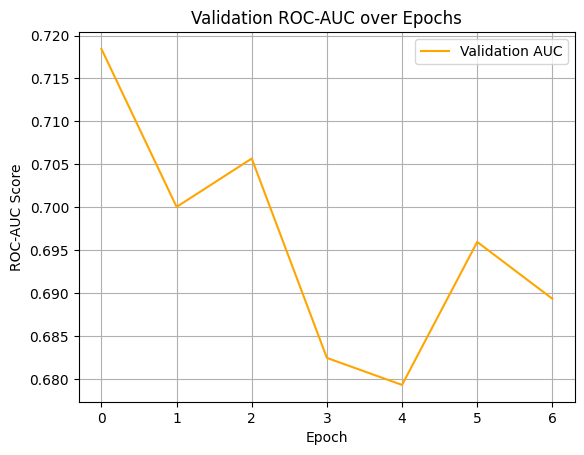

Epoch 7/10:
Average Training Loss: 0.5202
Validation ROC-AUC: 0.6893
--------------------------------------------------


Epoch 8/10: 100%|██████████| 969/969 [00:22<00:00, 43.51it/s]


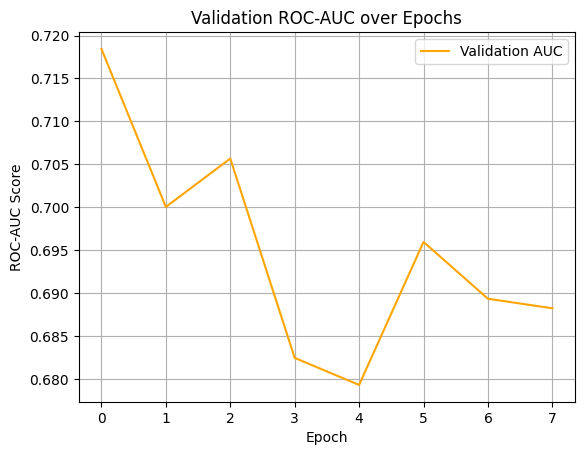

Epoch 8/10:
Average Training Loss: 0.4696
Validation ROC-AUC: 0.6882
--------------------------------------------------


Epoch 9/10: 100%|██████████| 969/969 [00:23<00:00, 40.96it/s]


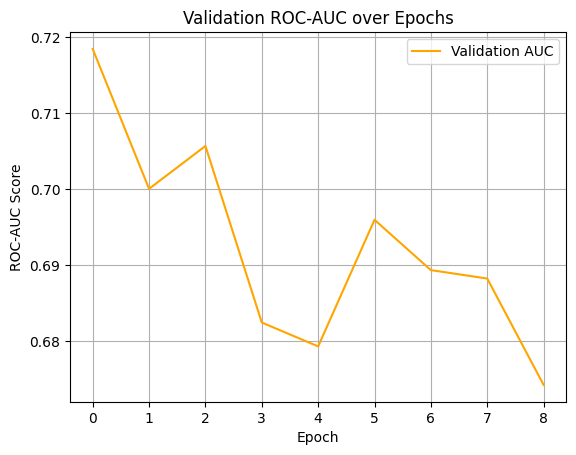

Epoch 9/10:
Average Training Loss: 0.4352
Validation ROC-AUC: 0.6742
--------------------------------------------------


Epoch 10/10: 100%|██████████| 969/969 [00:20<00:00, 46.30it/s]


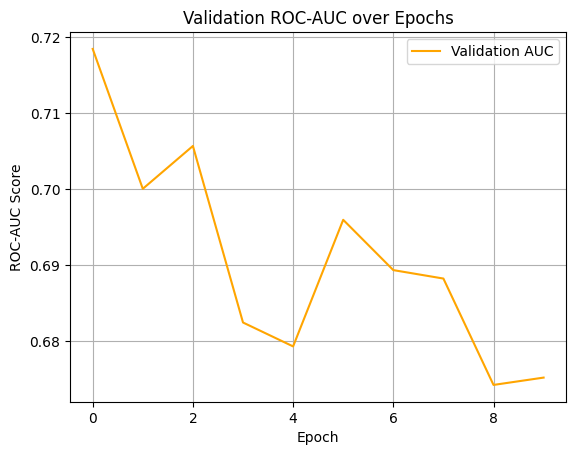

Epoch 10/10:
Average Training Loss: 0.3900
Validation ROC-AUC: 0.6752
--------------------------------------------------


{'train_losses': [0.8240417046251374,
  0.754767047231719,
  0.7023337697466091,
  0.657942624653087,
  0.6109750935321498,
  0.5663929650227475,
  0.5202149321681698,
  0.4696033490885153,
  0.43521215272077407,
  0.3899810408377564],
 'val_auc_scores': [0.7184381791765229,
  0.7000306192288758,
  0.7056666586616395,
  0.6824365701660643,
  0.6792905944933418,
  0.6959503067926658,
  0.6893319004334723,
  0.6882204524441349,
  0.6742234123029263,
  0.6751877679182526],
 'best_model': OrderedDict([('embs.0.weight',
               tensor([[ 1.0379,  0.1268,  0.5757, -0.0456,  0.2308,  0.5785, -1.1929, -0.4806],
                       [ 0.5015,  0.0283,  0.3649,  1.2391,  0.2970,  0.2684,  1.1051, -0.2899]],
                      device='cuda:0')),
              ('embs.1.weight',
               tensor([[ 1.2206, -0.9066,  1.2844,  1.1234, -0.0271,  0.5189, -0.5451, -0.6278],
                       [-0.6921, -1.5200, -0.1570,  0.8716, -1.7401, -0.8766,  0.6520, -0.7415],
                 

In [165]:
torch.cuda.empty_cache()
model = CreditTransformer(len(num_features), unique_counter, categorical_dim=8, hidden_dim=32, n_layers=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.01)
# criterion2 = AUCLoss(temperature=1.0)
criterion2 = ImprovedAUCLoss()
criterion1 = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
criterion = [criterion1, criterion2]
train_and_validate(model, train_loader, X_eval_num, X_eval_cat, y_eval, criterion, optimizer, device=device)

In [ ]:
X_train = prepare_cat_features(X_train, cat_features)
X_eval = prepare_cat_features(X_eval, cat_features)

In [14]:
# import optuna
# def function(trial):
#     iterations = trial.suggest_int('iterations', 100, 1000)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
#     depth = trial.suggest_int('depth', 3, 10)
#     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10)
#     random_seed = trial.suggest_int('random_seed', 1, 50)
#     model = cb.CatBoostClassifier(
#         iterations=iterations,
#         learning_rate=learning_rate,
#         depth=depth,
#         l2_leaf_reg=l2_leaf_reg,
#         random_seed=random_seed,
#         loss_function='Logloss',
#         eval_metric='AUC',
#         auto_class_weights='Balanced',
#         early_stopping_rounds=300,
#         task_type="GPU",
#         verbose=0,
#         cat_features=cat_features,
#     )
#     model.fit(X_train, y_train, eval_set=(X_eval, y_eval), use_best_model=True)
    
#     return model.best_score_['validation']['AUC']
    
# study = optuna.create_study(direction='maximize')
# study.optimize(function, n_trials=100)
# study.best_params


In [96]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

models = []

for train_index, test_index in cv.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = cb.CatBoostClassifier(
        iterations=2000,
        learning_rate=0.01,
        depth=6,
        l2_leaf_reg=3,
        random_seed=42,
        loss_function='Logloss',
        eval_metric='AUC',
        auto_class_weights='Balanced',
        early_stopping_rounds=300,
        task_type="GPU",
        verbose=1,
        cat_features=cat_features,
    )

    model.fit(X_train_cv, y_train_cv, eval_set=(X_test_cv, y_test_cv))
    models.append(model)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7151491	best: 0.7151491 (0)	total: 182ms	remaining: 6m 3s
1:	total: 348ms	remaining: 5m 47s
2:	total: 516ms	remaining: 5m 43s
3:	total: 704ms	remaining: 5m 51s
4:	total: 875ms	remaining: 5m 49s
5:	test: 0.7441060	best: 0.7441060 (5)	total: 1.07s	remaining: 5m 54s
6:	total: 1.24s	remaining: 5m 53s
7:	total: 1.41s	remaining: 5m 51s
8:	total: 1.59s	remaining: 5m 52s
9:	total: 1.76s	remaining: 5m 50s
10:	test: 0.7416205	best: 0.7457640 (6)	total: 1.93s	remaining: 5m 48s
11:	total: 2.1s	remaining: 5m 47s
12:	total: 2.26s	remaining: 5m 46s
13:	total: 2.44s	remaining: 5m 46s
14:	total: 2.6s	remaining: 5m 44s
15:	test: 0.7463944	best: 0.7467375 (13)	total: 2.77s	remaining: 5m 42s
16:	total: 2.92s	remaining: 5m 40s
17:	total: 3.09s	remaining: 5m 40s
18:	total: 3.28s	remaining: 5m 41s
19:	total: 3.44s	remaining: 5m 40s
20:	test: 0.7439756	best: 0.7488147 (17)	total: 3.59s	remaining: 5m 38s
21:	total: 3.75s	remaining: 5m 37s
22:	total: 3.91s	remaining: 5m 35s
23:	total: 4.06s	remaining

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7179775	best: 0.7179775 (0)	total: 163ms	remaining: 5m 25s
1:	total: 327ms	remaining: 5m 26s
2:	total: 491ms	remaining: 5m 27s
3:	total: 650ms	remaining: 5m 24s
4:	total: 804ms	remaining: 5m 20s
5:	test: 0.7434931	best: 0.7442157 (4)	total: 967ms	remaining: 5m 21s
6:	total: 1.12s	remaining: 5m 20s
7:	total: 1.28s	remaining: 5m 18s
8:	total: 1.44s	remaining: 5m 18s
9:	total: 1.61s	remaining: 5m 19s
10:	test: 0.7457898	best: 0.7457898 (10)	total: 1.77s	remaining: 5m 20s
11:	total: 1.94s	remaining: 5m 21s
12:	total: 2.1s	remaining: 5m 21s
13:	total: 2.27s	remaining: 5m 22s
14:	total: 2.43s	remaining: 5m 21s
15:	test: 0.7476200	best: 0.7482861 (13)	total: 2.59s	remaining: 5m 21s
16:	total: 2.77s	remaining: 5m 22s
17:	total: 2.94s	remaining: 5m 23s
18:	total: 3.1s	remaining: 5m 23s
19:	total: 3.27s	remaining: 5m 23s
20:	test: 0.7518867	best: 0.7518867 (20)	total: 3.43s	remaining: 5m 23s
21:	total: 3.58s	remaining: 5m 22s
22:	total: 3.74s	remaining: 5m 21s
23:	total: 3.91s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6774796	best: 0.6774796 (0)	total: 153ms	remaining: 5m 5s
1:	total: 316ms	remaining: 5m 15s
2:	total: 481ms	remaining: 5m 20s
3:	total: 638ms	remaining: 5m 18s
4:	total: 789ms	remaining: 5m 14s
5:	test: 0.7506472	best: 0.7506472 (5)	total: 943ms	remaining: 5m 13s
6:	total: 1.1s	remaining: 5m 14s
7:	total: 1.26s	remaining: 5m 13s
8:	total: 1.42s	remaining: 5m 13s
9:	total: 1.58s	remaining: 5m 13s
10:	test: 0.7464119	best: 0.7534373 (8)	total: 1.73s	remaining: 5m 12s
11:	total: 1.88s	remaining: 5m 11s
12:	total: 2.04s	remaining: 5m 11s
13:	total: 2.19s	remaining: 5m 10s
14:	total: 2.35s	remaining: 5m 10s
15:	test: 0.7466397	best: 0.7534373 (8)	total: 2.52s	remaining: 5m 12s
16:	total: 2.67s	remaining: 5m 10s
17:	total: 2.82s	remaining: 5m 10s
18:	total: 2.97s	remaining: 5m 9s
19:	total: 3.12s	remaining: 5m 8s
20:	test: 0.7448017	best: 0.7534373 (8)	total: 3.27s	remaining: 5m 8s
21:	total: 3.43s	remaining: 5m 8s
22:	total: 3.59s	remaining: 5m 8s
23:	total: 3.75s	remaining: 5m 8

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6741319	best: 0.6741319 (0)	total: 178ms	remaining: 5m 55s
1:	total: 351ms	remaining: 5m 51s
2:	total: 511ms	remaining: 5m 39s
3:	total: 673ms	remaining: 5m 36s
4:	total: 837ms	remaining: 5m 34s
5:	test: 0.7588885	best: 0.7623305 (4)	total: 1s	remaining: 5m 32s
6:	total: 1.16s	remaining: 5m 29s
7:	total: 1.31s	remaining: 5m 26s
8:	total: 1.47s	remaining: 5m 26s
9:	total: 1.64s	remaining: 5m 26s
10:	test: 0.7530225	best: 0.7623305 (4)	total: 1.8s	remaining: 5m 26s
11:	total: 1.97s	remaining: 5m 26s
12:	total: 2.16s	remaining: 5m 30s
13:	total: 2.34s	remaining: 5m 31s
14:	total: 2.51s	remaining: 5m 32s
15:	test: 0.7516637	best: 0.7623305 (4)	total: 2.68s	remaining: 5m 32s
16:	total: 2.85s	remaining: 5m 32s
17:	total: 3.02s	remaining: 5m 32s
18:	total: 3.19s	remaining: 5m 32s
19:	total: 3.36s	remaining: 5m 33s
20:	test: 0.7563797	best: 0.7623305 (4)	total: 3.52s	remaining: 5m 31s
21:	total: 3.68s	remaining: 5m 31s
22:	total: 3.85s	remaining: 5m 30s
23:	total: 4.01s	remaining: 5

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6896750	best: 0.6896750 (0)	total: 312ms	remaining: 10m 23s
1:	total: 564ms	remaining: 9m 23s
2:	total: 851ms	remaining: 9m 26s
3:	total: 1.06s	remaining: 8m 48s
4:	total: 1.26s	remaining: 8m 22s
5:	test: 0.7443634	best: 0.7443634 (5)	total: 1.47s	remaining: 8m 9s
6:	total: 1.67s	remaining: 7m 54s
7:	total: 1.85s	remaining: 7m 40s
8:	total: 2.05s	remaining: 7m 34s
9:	total: 2.24s	remaining: 7m 26s
10:	test: 0.7560341	best: 0.7580402 (9)	total: 2.44s	remaining: 7m 21s
11:	total: 2.63s	remaining: 7m 15s
12:	total: 2.8s	remaining: 7m 8s
13:	total: 3s	remaining: 7m 6s
14:	total: 3.21s	remaining: 7m 4s
15:	test: 0.7537169	best: 0.7580402 (9)	total: 3.4s	remaining: 7m 2s
16:	total: 3.59s	remaining: 6m 58s
17:	total: 3.76s	remaining: 6m 54s
18:	total: 3.96s	remaining: 6m 53s
19:	total: 4.17s	remaining: 6m 52s
20:	test: 0.7575108	best: 0.7580402 (9)	total: 4.37s	remaining: 6m 51s
21:	total: 4.58s	remaining: 6m 51s
22:	total: 4.77s	remaining: 6m 50s
23:	total: 4.99s	remaining: 6m 50s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7152550	best: 0.7152550 (0)	total: 260ms	remaining: 8m 39s
1:	total: 509ms	remaining: 8m 28s
2:	total: 733ms	remaining: 8m 7s
3:	total: 942ms	remaining: 7m 50s
4:	total: 1.13s	remaining: 7m 32s
5:	test: 0.7411712	best: 0.7411712 (5)	total: 1.35s	remaining: 7m 29s
6:	total: 1.56s	remaining: 7m 24s
7:	total: 1.75s	remaining: 7m 16s
8:	total: 1.94s	remaining: 7m 8s
9:	total: 2.14s	remaining: 7m 6s
10:	test: 0.7519511	best: 0.7519511 (10)	total: 2.32s	remaining: 7m
11:	total: 2.52s	remaining: 6m 57s
12:	total: 2.71s	remaining: 6m 54s
13:	total: 2.92s	remaining: 6m 53s
14:	total: 3.12s	remaining: 6m 53s
15:	test: 0.7570018	best: 0.7570018 (15)	total: 3.32s	remaining: 6m 51s
16:	total: 3.5s	remaining: 6m 47s
17:	total: 3.69s	remaining: 6m 46s
18:	total: 3.9s	remaining: 6m 46s
19:	total: 4.11s	remaining: 6m 47s
20:	test: 0.7563860	best: 0.7570018 (15)	total: 4.31s	remaining: 6m 46s
21:	total: 4.5s	remaining: 6m 44s
22:	total: 4.69s	remaining: 6m 43s
23:	total: 4.89s	remaining: 6m 4

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7551166	best: 0.7551166 (0)	total: 253ms	remaining: 8m 26s
1:	total: 522ms	remaining: 8m 41s
2:	total: 766ms	remaining: 8m 29s
3:	total: 975ms	remaining: 8m 6s
4:	total: 1.2s	remaining: 7m 59s
5:	test: 0.7915787	best: 0.7915787 (5)	total: 1.4s	remaining: 7m 45s
6:	total: 1.61s	remaining: 7m 37s
7:	total: 1.81s	remaining: 7m 30s
8:	total: 2.02s	remaining: 7m 27s
9:	total: 2.22s	remaining: 7m 21s
10:	test: 0.7897815	best: 0.7915787 (5)	total: 2.4s	remaining: 7m 14s
11:	total: 2.59s	remaining: 7m 8s
12:	total: 2.8s	remaining: 7m 7s
13:	total: 3s	remaining: 7m 4s
14:	total: 3.18s	remaining: 7m
15:	test: 0.7890353	best: 0.7916808 (11)	total: 3.4s	remaining: 7m 1s
16:	total: 3.66s	remaining: 7m 6s
17:	total: 3.93s	remaining: 7m 12s
18:	total: 4.2s	remaining: 7m 18s
19:	total: 4.53s	remaining: 7m 28s
20:	test: 0.7906110	best: 0.7916808 (11)	total: 4.78s	remaining: 7m 30s
21:	total: 5.02s	remaining: 7m 31s
22:	total: 5.27s	remaining: 7m 33s
23:	total: 5.5s	remaining: 7m 32s
24:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7261528	best: 0.7261528 (0)	total: 150ms	remaining: 4m 59s
1:	total: 306ms	remaining: 5m 6s
2:	total: 459ms	remaining: 5m 5s
3:	total: 616ms	remaining: 5m 7s
4:	total: 766ms	remaining: 5m 5s
5:	test: 0.7638575	best: 0.7638575 (5)	total: 918ms	remaining: 5m 5s
6:	total: 1.07s	remaining: 5m 5s
7:	total: 1.23s	remaining: 5m 5s
8:	total: 1.38s	remaining: 5m 4s
9:	total: 1.53s	remaining: 5m 4s
10:	test: 0.7650813	best: 0.7677032 (7)	total: 1.69s	remaining: 5m 6s
11:	total: 1.85s	remaining: 5m 6s
12:	total: 2s	remaining: 5m 5s
13:	total: 2.15s	remaining: 5m 5s
14:	total: 2.3s	remaining: 5m 4s
15:	test: 0.7713258	best: 0.7713258 (15)	total: 2.45s	remaining: 5m 3s
16:	total: 2.6s	remaining: 5m 3s
17:	total: 2.76s	remaining: 5m 3s
18:	total: 2.91s	remaining: 5m 3s
19:	total: 3.07s	remaining: 5m 3s
20:	test: 0.7710713	best: 0.7715159 (16)	total: 3.22s	remaining: 5m 3s
21:	total: 3.38s	remaining: 5m 3s
22:	total: 3.52s	remaining: 5m 2s
23:	total: 3.67s	remaining: 5m 2s
24:	total: 3.82s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7539443	best: 0.7539443 (0)	total: 160ms	remaining: 5m 19s
1:	total: 311ms	remaining: 5m 10s
2:	total: 468ms	remaining: 5m 11s
3:	total: 627ms	remaining: 5m 12s
4:	total: 788ms	remaining: 5m 14s
5:	test: 0.7513044	best: 0.7622694 (1)	total: 947ms	remaining: 5m 14s
6:	total: 1.1s	remaining: 5m 13s
7:	total: 1.26s	remaining: 5m 13s
8:	total: 1.42s	remaining: 5m 13s
9:	total: 1.57s	remaining: 5m 13s
10:	test: 0.7698941	best: 0.7698941 (10)	total: 1.74s	remaining: 5m 13s
11:	total: 1.91s	remaining: 5m 15s
12:	total: 2.1s	remaining: 5m 21s
13:	total: 2.26s	remaining: 5m 20s
14:	total: 2.42s	remaining: 5m 20s
15:	test: 0.7782533	best: 0.7782533 (15)	total: 2.58s	remaining: 5m 20s
16:	total: 2.73s	remaining: 5m 18s
17:	total: 2.88s	remaining: 5m 17s
18:	total: 3.05s	remaining: 5m 17s
19:	total: 3.21s	remaining: 5m 17s
20:	test: 0.7752329	best: 0.7783154 (19)	total: 3.36s	remaining: 5m 16s
21:	total: 3.51s	remaining: 5m 15s
22:	total: 3.67s	remaining: 5m 15s
23:	total: 3.83s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7421439	best: 0.7421439 (0)	total: 189ms	remaining: 6m 17s
1:	total: 381ms	remaining: 6m 20s
2:	total: 578ms	remaining: 6m 24s
3:	total: 762ms	remaining: 6m 20s
4:	total: 957ms	remaining: 6m 21s
5:	test: 0.7121451	best: 0.7421439 (0)	total: 1.15s	remaining: 6m 20s
6:	total: 1.33s	remaining: 6m 18s
7:	total: 1.53s	remaining: 6m 20s
8:	total: 1.73s	remaining: 6m 22s
9:	total: 1.93s	remaining: 6m 24s
10:	test: 0.7124216	best: 0.7421439 (0)	total: 2.13s	remaining: 6m 24s
11:	total: 2.31s	remaining: 6m 22s
12:	total: 2.5s	remaining: 6m 22s
13:	total: 2.69s	remaining: 6m 21s
14:	total: 2.89s	remaining: 6m 22s
15:	test: 0.7160802	best: 0.7421439 (0)	total: 3.08s	remaining: 6m 21s
16:	total: 3.27s	remaining: 6m 21s
17:	total: 3.47s	remaining: 6m 22s
18:	total: 3.67s	remaining: 6m 22s
19:	total: 3.9s	remaining: 6m 26s
20:	test: 0.7195307	best: 0.7421439 (0)	total: 4.14s	remaining: 6m 30s
21:	total: 4.38s	remaining: 6m 33s
22:	total: 4.61s	remaining: 6m 36s
23:	total: 4.83s	remaining:

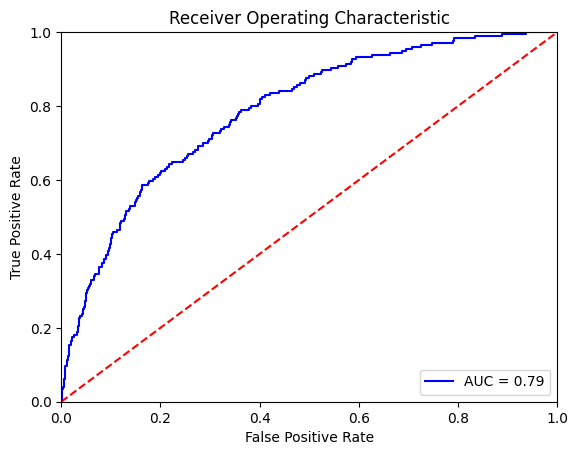

In [19]:
from sklearn.metrics import roc_curve, auc
eval_predictions = np.zeros(len(X_eval))
for model in models:
    eval_predictions += model.predict_proba(X_eval)[:, 1] / len(models)

fpr, tpr, threshold = roc_curve(y_eval, eval_predictions)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [102]:
data_test=data_test.drop(columns=['smpl','id'])

In [105]:
data_test = prepare_cat_features(data_test, cat_features)

In [106]:
test_predictions = np.zeros(len(X_test))
for model in models:
    test_predictions += model.predict_proba(data_test)[:, 1] / len(models)

submit = pd.concat([X_test['id'], pd.DataFrame(test_predictions)], axis=1)
baseline_submit = pd.read_csv('baseline_submission_case1.csv')
ordered_submit = baseline_submit[['id']].merge(submit, on='id', how='left')
ordered_submit.columns = ['id', 'target']
ordered_submit.to_csv('catboost2_submission.csv', index=False)

Ensemble

In [107]:
new_data = pd.DataFrame({f'catboost_{i}': np.zeros(len(X_train)) for i in range(10)})
for i, model in enumerate(models):
    prediction = model.predict_proba(X_train)[:, 1]
    new_data.iloc[:, i] += prediction
new_data.head()

,catboost_0,catboost_1,catboost_2,catboost_3,catboost_4,catboost_5,catboost_6,catboost_7,catboost_8,catboost_9
0,0.418327,0.405307,0.200685,0.304181,0.457756,0.403958,0.480652,0.429740,0.416484,0.498640
1,0.415021,0.461127,0.267276,0.360012,0.508839,0.471199,0.492494,0.482651,0.459759,0.500482
2,0.206324,0.383134,0.126407,0.162814,0.463240,0.157835,0.475996,0.356457,0.383128,0.498752
3,0.124418,0.244147,0.046370,0.118702,0.421221,0.158626,0.439331,0.224847,0.258361,0.496754
4,0.601062,0.551993,0.556905,0.521307,0.538003,0.677396,0.530080,0.569056,0.540243,0.503183


In [108]:
new_data.shape, y_train.shape

((38731, 10), (38731,))

In [21]:
new_data_eval = pd.DataFrame({f'catboost_{i}': np.zeros(len(X_eval)) for i in range(10)})
for i, model in enumerate(models):
    prediction = model.predict_proba(X_eval)[:, 1]
    new_data_eval.iloc[:, i] += prediction
new_data_eval.head()

,catboost_0,catboost_1,catboost_2,catboost_3,catboost_4,catboost_5,catboost_6,catboost_7,catboost_8,catboost_9
0,0.325467,0.302672,0.454853,0.421526,0.416794,0.419138,0.478469,0.484383,0.383147,0.471065
1,0.738803,0.783687,0.619958,0.648008,0.619929,0.719914,0.528941,0.520846,0.678968,0.568413
2,0.590389,0.601526,0.543532,0.563678,0.545911,0.581573,0.513183,0.505277,0.624640,0.535042
3,0.050727,0.032036,0.220310,0.161713,0.299818,0.042496,0.431307,0.445453,0.149929,0.359604
4,0.216987,0.062854,0.376182,0.337873,0.376861,0.164114,0.496877,0.478647,0.335630,0.473025


In [77]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))


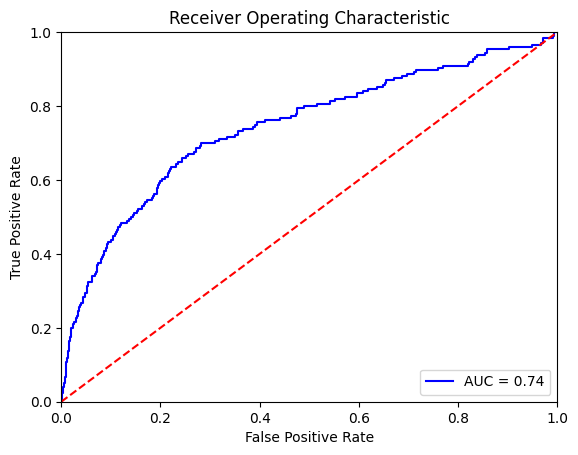

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(class_weight=class_weights_dict, max_iter=2000, random_state=52, )
param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga', 'lbfgs']}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc',)
grid_search.fit(new_data, y_train)
lr = grid_search.best_estimator_
eval_preds = lr.predict_proba(new_data_eval)
fpr, tpr, threshold = roc_curve(y_eval, eval_preds[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(new_data)[:, 1:]
X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out()[1:])
X_eval_poly = poly.transform(new_data_eval)[:, 1:]
X_eval_poly = pd.DataFrame(X_eval_poly, columns=poly.get_feature_names_out()[1:])
X_train_poly

,catboost_0,catboost_1,catboost_2,catboost_3,catboost_4,catboost_5,catboost_6,catboost_7,catboost_8,catboost_9,...,catboost_6^2,catboost_6 catboost_7,catboost_6 catboost_8,catboost_6 catboost_9,catboost_7^2,catboost_7 catboost_8,catboost_7 catboost_9,catboost_8^2,catboost_8 catboost_9,catboost_9^2
0,0.418327,0.405307,0.200685,0.304181,0.457756,0.403958,0.480652,0.429740,0.416484,0.498640,...,0.231026,0.206555,0.200183,0.239672,0.184676,0.178979,0.214285,0.173459,0.207675,0.248642
1,0.415021,0.461127,0.267276,0.360012,0.508839,0.471199,0.492494,0.482651,0.459759,0.500482,...,0.242550,0.237703,0.226428,0.246484,0.232952,0.221903,0.241558,0.211378,0.230101,0.250482
2,0.206324,0.383134,0.126407,0.162814,0.463240,0.157835,0.475996,0.356457,0.383128,0.498752,...,0.226572,0.169672,0.182367,0.237404,0.127061,0.136569,0.177783,0.146787,0.191086,0.248754
3,0.124418,0.244147,0.046370,0.118702,0.421221,0.158626,0.439331,0.224847,0.258361,0.496754,...,0.193012,0.098782,0.113506,0.218239,0.050556,0.058092,0.111694,0.066750,0.128342,0.246764
4,0.601062,0.551993,0.556905,0.521307,0.538003,0.677396,0.530080,0.569056,0.540243,0.503183,...,0.280985,0.301645,0.286372,0.266727,0.323824,0.307428,0.286339,0.291862,0.271841,0.253193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38726,0.330102,0.392311,0.229540,0.269541,0.450976,0.343528,0.470966,0.392356,0.412134,0.498752,...,0.221809,0.184786,0.194101,0.234895,0.153943,0.161703,0.195688,0.169854,0.205553,0.248754
38727,0.727651,0.651277,0.756096,0.757576,0.556069,0.719139,0.531377,0.669432,0.670884,0.503183,...,0.282362,0.355721,0.356493,0.267380,0.448139,0.449111,0.336847,0.450086,0.337578,0.253193
38728,0.400549,0.489829,0.397833,0.471733,0.482887,0.433337,0.498699,0.468647,0.452988,0.502961,...,0.248701,0.233714,0.225905,0.250826,0.219630,0.212291,0.235711,0.205198,0.227835,0.252970
38729,0.334494,0.410147,0.301955,0.306105,0.467844,0.359169,0.481968,0.397571,0.415691,0.498752,...,0.232293,0.191617,0.200350,0.240383,0.158063,0.165267,0.198290,0.172799,0.207327,0.248754


In [110]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=52)
models_final = []
for train_index, test_index in cv.split(X_train_poly, y_train):
    X_train_cv, X_test_cv = X_train_poly.iloc[train_index], X_train_poly.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    model = cb.CatBoostClassifier(
            iterations=1000,
            learning_rate=0.01,
            depth=4,
            l2_leaf_reg=3,
            random_seed=42,
            loss_function='Logloss',
            eval_metric='AUC',
            auto_class_weights='Balanced',
            early_stopping_rounds=200,
            task_type="GPU",
            verbose=1,
        )
    
    model.fit(X_train_cv, y_train_cv, eval_set=(X_test_cv, y_test_cv))
    models_final.append(model)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8596355	best: 0.8596355 (0)	total: 48.6ms	remaining: 48.5s
1:	total: 85.2ms	remaining: 42.5s
2:	total: 118ms	remaining: 39.2s
3:	total: 152ms	remaining: 37.8s
4:	total: 188ms	remaining: 37.4s
5:	test: 0.8866549	best: 0.8928322 (3)	total: 224ms	remaining: 37.1s
6:	total: 263ms	remaining: 37.3s
7:	total: 299ms	remaining: 37s
8:	total: 336ms	remaining: 37s
9:	total: 372ms	remaining: 36.8s
10:	test: 0.8958626	best: 0.8958626 (10)	total: 408ms	remaining: 36.7s
11:	total: 443ms	remaining: 36.5s
12:	total: 478ms	remaining: 36.3s
13:	total: 533ms	remaining: 37.5s
14:	total: 568ms	remaining: 37.3s
15:	test: 0.8966978	best: 0.8969913 (14)	total: 605ms	remaining: 37.2s
16:	total: 652ms	remaining: 37.7s
17:	total: 687ms	remaining: 37.5s
18:	total: 723ms	remaining: 37.3s
19:	total: 760ms	remaining: 37.2s
20:	test: 0.8963098	best: 0.8969913 (14)	total: 795ms	remaining: 37s
21:	total: 829ms	remaining: 36.9s
22:	total: 864ms	remaining: 36.7s
23:	total: 899ms	remaining: 36.6s
24:	total: 935m

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8718109	best: 0.8718109 (0)	total: 34.7ms	remaining: 34.7s
1:	total: 68.5ms	remaining: 34.2s
2:	total: 103ms	remaining: 34.4s
3:	total: 138ms	remaining: 34.4s
4:	total: 172ms	remaining: 34.3s
5:	test: 0.8990185	best: 0.8990185 (5)	total: 207ms	remaining: 34.3s
6:	total: 242ms	remaining: 34.3s
7:	total: 299ms	remaining: 37s
8:	total: 337ms	remaining: 37.1s
9:	total: 372ms	remaining: 36.8s
10:	test: 0.9102823	best: 0.9102823 (10)	total: 405ms	remaining: 36.4s
11:	total: 439ms	remaining: 36.1s
12:	total: 474ms	remaining: 36s
13:	total: 508ms	remaining: 35.7s
14:	total: 541ms	remaining: 35.5s
15:	test: 0.9102618	best: 0.9102823 (10)	total: 576ms	remaining: 35.4s
16:	total: 613ms	remaining: 35.4s
17:	total: 648ms	remaining: 35.4s
18:	total: 683ms	remaining: 35.3s
19:	total: 719ms	remaining: 35.2s
20:	test: 0.9140275	best: 0.9140275 (20)	total: 756ms	remaining: 35.3s
21:	total: 792ms	remaining: 35.2s
22:	total: 826ms	remaining: 35.1s
23:	total: 860ms	remaining: 35s
24:	total: 894m

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8940684	best: 0.8940684 (0)	total: 46.2ms	remaining: 46.2s
1:	total: 84.3ms	remaining: 42s
2:	total: 127ms	remaining: 42.3s
3:	total: 161ms	remaining: 40s
4:	total: 198ms	remaining: 39.3s
5:	test: 0.9212617	best: 0.9212617 (5)	total: 236ms	remaining: 39s
6:	total: 273ms	remaining: 38.8s
7:	total: 309ms	remaining: 38.3s
8:	total: 344ms	remaining: 37.8s
9:	total: 378ms	remaining: 37.4s
10:	test: 0.9267946	best: 0.9267946 (10)	total: 412ms	remaining: 37s
11:	total: 446ms	remaining: 36.7s
12:	total: 481ms	remaining: 36.5s
13:	total: 517ms	remaining: 36.4s
14:	total: 556ms	remaining: 36.5s
15:	test: 0.9273351	best: 0.9278661 (14)	total: 595ms	remaining: 36.6s
16:	total: 635ms	remaining: 36.7s
17:	total: 671ms	remaining: 36.6s
18:	total: 705ms	remaining: 36.4s
19:	total: 740ms	remaining: 36.3s
20:	test: 0.9281080	best: 0.9281080 (20)	total: 795ms	remaining: 37.1s
21:	total: 831ms	remaining: 36.9s
22:	total: 865ms	remaining: 36.7s
23:	total: 900ms	remaining: 36.6s
24:	total: 936ms	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9031108	best: 0.9031108 (0)	total: 35.1ms	remaining: 35.1s
1:	total: 70.3ms	remaining: 35.1s
2:	total: 104ms	remaining: 34.6s
3:	total: 137ms	remaining: 34.1s
4:	total: 171ms	remaining: 34.1s
5:	test: 0.9213796	best: 0.9233967 (2)	total: 205ms	remaining: 34s
6:	total: 241ms	remaining: 34.2s
7:	total: 277ms	remaining: 34.4s
8:	total: 312ms	remaining: 34.4s
9:	total: 346ms	remaining: 34.3s
10:	test: 0.9289406	best: 0.9294276 (8)	total: 381ms	remaining: 34.3s
11:	total: 416ms	remaining: 34.3s
12:	total: 451ms	remaining: 34.2s
13:	total: 488ms	remaining: 34.4s
14:	total: 524ms	remaining: 34.4s
15:	test: 0.9311180	best: 0.9311180 (15)	total: 566ms	remaining: 34.8s
16:	total: 633ms	remaining: 36.6s
17:	total: 672ms	remaining: 36.7s
18:	total: 709ms	remaining: 36.6s
19:	total: 745ms	remaining: 36.5s
20:	test: 0.9334179	best: 0.9334179 (20)	total: 778ms	remaining: 36.3s
21:	total: 813ms	remaining: 36.1s
22:	total: 846ms	remaining: 36s
23:	total: 881ms	remaining: 35.8s
24:	total: 918

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9082526	best: 0.9082526 (0)	total: 34.5ms	remaining: 34.5s
1:	total: 68.9ms	remaining: 34.4s
2:	total: 103ms	remaining: 34.2s
3:	total: 141ms	remaining: 35.2s
4:	total: 178ms	remaining: 35.4s
5:	test: 0.9311839	best: 0.9328429 (3)	total: 216ms	remaining: 35.7s
6:	total: 255ms	remaining: 36.2s
7:	total: 296ms	remaining: 36.7s
8:	total: 330ms	remaining: 36.4s
9:	total: 364ms	remaining: 36s
10:	test: 0.9338405	best: 0.9338405 (10)	total: 402ms	remaining: 36.2s
11:	total: 460ms	remaining: 37.8s
12:	total: 496ms	remaining: 37.6s
13:	total: 531ms	remaining: 37.4s
14:	total: 564ms	remaining: 37.1s
15:	test: 0.9351679	best: 0.9351679 (15)	total: 609ms	remaining: 37.4s
16:	total: 644ms	remaining: 37.2s
17:	total: 680ms	remaining: 37.1s
18:	total: 715ms	remaining: 36.9s
19:	total: 749ms	remaining: 36.7s
20:	test: 0.9384088	best: 0.9384088 (20)	total: 783ms	remaining: 36.5s
21:	total: 820ms	remaining: 36.4s
22:	total: 854ms	remaining: 36.3s
23:	total: 888ms	remaining: 36.1s
24:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9042969	best: 0.9042969 (0)	total: 34.4ms	remaining: 34.3s
1:	total: 69.4ms	remaining: 34.6s
2:	total: 108ms	remaining: 36s
3:	total: 145ms	remaining: 36s
4:	total: 180ms	remaining: 35.9s
5:	test: 0.9318720	best: 0.9318720 (5)	total: 217ms	remaining: 36s
6:	total: 256ms	remaining: 36.3s
7:	total: 322ms	remaining: 39.9s
8:	total: 356ms	remaining: 39.2s
9:	total: 390ms	remaining: 38.6s
10:	test: 0.9360743	best: 0.9360743 (10)	total: 429ms	remaining: 38.6s
11:	total: 464ms	remaining: 38.2s
12:	total: 498ms	remaining: 37.8s
13:	total: 532ms	remaining: 37.5s
14:	total: 566ms	remaining: 37.2s
15:	test: 0.9390058	best: 0.9390058 (15)	total: 602ms	remaining: 37.1s
16:	total: 637ms	remaining: 36.8s
17:	total: 671ms	remaining: 36.6s
18:	total: 705ms	remaining: 36.4s
19:	total: 740ms	remaining: 36.3s
20:	test: 0.9438899	best: 0.9438899 (20)	total: 774ms	remaining: 36.1s
21:	total: 809ms	remaining: 36s
22:	total: 843ms	remaining: 35.8s
23:	total: 877ms	remaining: 35.7s
24:	total: 911ms	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8860313	best: 0.8860313 (0)	total: 40.2ms	remaining: 40.2s
1:	total: 78.1ms	remaining: 39s
2:	total: 120ms	remaining: 39.8s
3:	total: 168ms	remaining: 41.9s
4:	total: 217ms	remaining: 43.2s
5:	test: 0.9037926	best: 0.9037926 (5)	total: 279ms	remaining: 46.2s
6:	total: 319ms	remaining: 45.3s
7:	total: 359ms	remaining: 44.6s
8:	total: 398ms	remaining: 43.9s
9:	total: 434ms	remaining: 43s
10:	test: 0.9139222	best: 0.9139222 (10)	total: 471ms	remaining: 42.4s
11:	total: 505ms	remaining: 41.6s
12:	total: 541ms	remaining: 41.1s
13:	total: 587ms	remaining: 41.3s
14:	total: 629ms	remaining: 41.3s
15:	test: 0.9138122	best: 0.9142175 (14)	total: 675ms	remaining: 41.5s
16:	total: 716ms	remaining: 41.4s
17:	total: 754ms	remaining: 41.2s
18:	total: 800ms	remaining: 41.3s
19:	total: 841ms	remaining: 41.2s
20:	test: 0.9137572	best: 0.9142175 (14)	total: 885ms	remaining: 41.3s
21:	total: 929ms	remaining: 41.3s
22:	total: 968ms	remaining: 41.1s
23:	total: 1.01s	remaining: 41.2s
24:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8851657	best: 0.8851657 (0)	total: 34.1ms	remaining: 34.1s
1:	total: 68.2ms	remaining: 34.1s
2:	total: 103ms	remaining: 34.1s
3:	total: 136ms	remaining: 33.9s
4:	total: 170ms	remaining: 33.9s
5:	test: 0.8959017	best: 0.8968411 (3)	total: 206ms	remaining: 34.1s
6:	total: 244ms	remaining: 34.7s
7:	total: 281ms	remaining: 34.9s
8:	total: 316ms	remaining: 34.8s
9:	total: 351ms	remaining: 34.7s
10:	test: 0.9115406	best: 0.9115406 (10)	total: 384ms	remaining: 34.5s
11:	total: 420ms	remaining: 34.6s
12:	total: 454ms	remaining: 34.4s
13:	total: 488ms	remaining: 34.3s
14:	total: 522ms	remaining: 34.3s
15:	test: 0.9142379	best: 0.9142379 (15)	total: 556ms	remaining: 34.2s
16:	total: 592ms	remaining: 34.2s
17:	total: 626ms	remaining: 34.1s
18:	total: 663ms	remaining: 34.2s
19:	total: 698ms	remaining: 34.2s
20:	test: 0.9144893	best: 0.9144893 (20)	total: 733ms	remaining: 34.2s
21:	total: 767ms	remaining: 34.1s
22:	total: 803ms	remaining: 34.1s
23:	total: 838ms	remaining: 34.1s
24:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8914125	best: 0.8914125 (0)	total: 40.9ms	remaining: 40.8s
1:	total: 83.3ms	remaining: 41.6s
2:	total: 134ms	remaining: 44.5s
3:	total: 177ms	remaining: 44s
4:	total: 216ms	remaining: 42.9s
5:	test: 0.9130893	best: 0.9155926 (3)	total: 259ms	remaining: 43s
6:	total: 301ms	remaining: 42.7s
7:	total: 341ms	remaining: 42.3s
8:	total: 385ms	remaining: 42.3s
9:	total: 423ms	remaining: 41.9s
10:	test: 0.9191487	best: 0.9202078 (9)	total: 467ms	remaining: 42s
11:	total: 506ms	remaining: 41.7s
12:	total: 550ms	remaining: 41.7s
13:	total: 592ms	remaining: 41.7s
14:	total: 632ms	remaining: 41.5s
15:	test: 0.9187434	best: 0.9202078 (9)	total: 685ms	remaining: 42.1s
16:	total: 730ms	remaining: 42.2s
17:	total: 771ms	remaining: 42.1s
18:	total: 816ms	remaining: 42.1s
19:	total: 857ms	remaining: 42s
20:	test: 0.9211908	best: 0.9218833 (19)	total: 911ms	remaining: 42.5s
21:	total: 952ms	remaining: 42.3s
22:	total: 991ms	remaining: 42.1s
23:	total: 1.03s	remaining: 41.8s
24:	total: 1.06s	re

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8932620	best: 0.8932620 (0)	total: 39.1ms	remaining: 39s
1:	total: 73.5ms	remaining: 36.7s
2:	total: 107ms	remaining: 35.7s
3:	total: 142ms	remaining: 35.5s
4:	total: 176ms	remaining: 35s
5:	test: 0.9296990	best: 0.9306463 (4)	total: 211ms	remaining: 35s
6:	total: 245ms	remaining: 34.8s
7:	total: 284ms	remaining: 35.2s
8:	total: 318ms	remaining: 35s
9:	total: 353ms	remaining: 35s
10:	test: 0.9318327	best: 0.9318327 (10)	total: 388ms	remaining: 34.8s
11:	total: 422ms	remaining: 34.7s
12:	total: 456ms	remaining: 34.6s
13:	total: 490ms	remaining: 34.5s
14:	total: 525ms	remaining: 34.4s
15:	test: 0.9334679	best: 0.9334679 (15)	total: 560ms	remaining: 34.4s
16:	total: 595ms	remaining: 34.4s
17:	total: 628ms	remaining: 34.3s
18:	total: 663ms	remaining: 34.2s
19:	total: 704ms	remaining: 34.5s
20:	test: 0.9356202	best: 0.9356202 (20)	total: 741ms	remaining: 34.5s
21:	total: 774ms	remaining: 34.4s
22:	total: 808ms	remaining: 34.3s
23:	total: 843ms	remaining: 34.3s
24:	total: 877ms	re

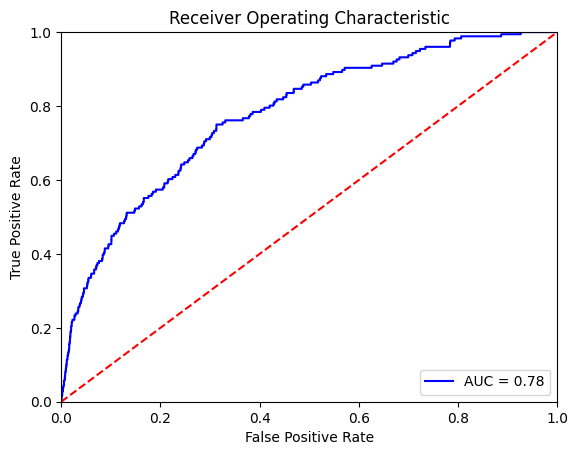

In [37]:
final_preds = np.zeros(len(X_eval_poly))
for model in models_final:
    final_preds += model.predict_proba(X_eval_poly)[:, 1] / len(models_final)
final_preds

fpr, tpr, threshold = roc_curve(y_eval, final_preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [111]:
data_test_id = pd.DataFrame({'id': X_test['id']})

In [112]:
data_test = prepare_cat_features(X_test, cat_features).drop(columns=['id'])
new_data_test = pd.DataFrame({f'catboost_{i}': np.zeros(len(X_test)) for i in range(10)})
for i, model in enumerate(models):
    prediction = model.predict_proba(data_test)[:, 1]
    new_data_test.iloc[:, i] += prediction
new_data_test.head()
new_data_test = poly.transform(new_data_test)[:, 1:]
new_data_test = pd.DataFrame(new_data_test, columns=poly.get_feature_names_out()[1:])
final_prediction = np.zeros(len(X_test))
for model in models_final:
    final_prediction += model.predict_proba(new_data_test)[:, 1] / len(models_final)

submit = pd.concat([data_test_id, pd.DataFrame(final_prediction)], axis=1)
baseline_submit = pd.read_csv('baseline_submission_case1.csv')
ordered_submit = baseline_submit[['id']].merge(submit, on='id', how='left')
ordered_submit.columns = ['id', 'target']
ordered_submit.to_csv('catboost_submission_ensemble.csv', index=False)

In [60]:
ordered_submit

,id,target
0,50623,0.005691
1,50624,0.006322
2,50625,0.658222
3,50626,0.678811
4,50627,0.015898
...,...,...
19821,50618,0.337640
19822,50619,0.484198
19823,50620,0.006759
19824,50621,0.003552


Mean pooling

In [38]:
data_test = prepare_cat_features(X_test, cat_features)
data_test_id = pd.DataFrame({'id': data_test.id})

data_test = data_test.drop(columns=['id'])
data_test_id.head()


,id
0,38731
1,38732
2,38733
3,38734
4,38735


In [ ]:
predictions = np.zeros(len(data_test))
for i, model in enumerate(models):
    predictions += model.predict_proba(data_test)[:, 1] / len(models)
predictions

array([0.63063434, 0.53874334, 0.51826713, ..., 0.54760504, 0.54547659,
       0.61141651])

In [ ]:
submit = pd.concat([data_test_id, pd.DataFrame(predictions)], axis=1)
submit.columns = ['id', 'target']
submit.to_csv('catboost_submission.csv', index=False)

In [ ]:
submit

,id,target
0,38731,0.630634
1,38732,0.538743
2,38733,0.518267
3,38734,0.484619
4,38735,0.622605
...,...,...
19821,56564,0.269462
19822,56565,0.214060
19823,56566,0.547605
19824,56567,0.545477


In [ ]:
baseline_submit = pd.read_csv('baseline_submission_case1.csv')
baseline_submit

,id,target
0,50623,0.012510
1,50624,0.872382
2,50625,0.038267
3,50626,0.044012
4,50627,0.013707
...,...,...
19821,50618,0.029699
19822,50619,0.016422
19823,50620,0.012493
19824,50621,0.015039


In [ ]:
ordered_submit = baseline_submit[['id']].merge(submit, on='id', how='left')
ordered_submit.to_csv('catboost_submission.csv', index=False)

In [ ]:
ordered_submit

,id,target
0,50623,0.373590
1,50624,0.302817
2,50625,0.597286
3,50626,0.601391
4,50627,0.359510
...,...,...
19821,50618,0.544160
19822,50619,0.527407
19823,50620,0.287710
19824,50621,0.365739


In [ ]:
new_data = pd.DataFrame({f'catboost_{i}': np.zeros(len(X_train)) for i in range(10)})
for i, model in enumerate(models):
    prediction = model.predict_proba(data)[:, 1]
    new_data.iloc[:, i] += prediction
new_data.head()

,catboost_0,catboost_1,catboost_2,catboost_3,catboost_4,catboost_5,catboost_6,catboost_7,catboost_8,catboost_9
0,0.391166,0.406144,0.208155,0.347751,0.456721,0.479933,0.497634,0.463319,0.484128,0.498020
1,0.424505,0.416264,0.266909,0.398214,0.477888,0.502576,0.502504,0.488645,0.476045,0.501097
2,0.198590,0.203699,0.164716,0.190722,0.432906,0.468471,0.495126,0.361344,0.447704,0.498225
3,0.152208,0.121951,0.052084,0.163946,0.363938,0.426430,0.485657,0.274580,0.366098,0.495906
4,0.602693,0.618386,0.526848,0.587303,0.552315,0.538279,0.509666,0.550744,0.542581,0.503783
